Original features: 512
Reduced features after PCA: 79

🔧 Validation Accuracy for Different k:
k=1 --> Validation Accuracy: 0.44
k=2 --> Validation Accuracy: 0.38
k=3 --> Validation Accuracy: 0.45
k=4 --> Validation Accuracy: 0.51
k=5 --> Validation Accuracy: 0.42
k=6 --> Validation Accuracy: 0.51
k=7 --> Validation Accuracy: 0.45
k=8 --> Validation Accuracy: 0.44
k=9 --> Validation Accuracy: 0.48
k=10 --> Validation Accuracy: 0.48
k=11 --> Validation Accuracy: 0.53
k=12 --> Validation Accuracy: 0.52
k=13 --> Validation Accuracy: 0.49
k=14 --> Validation Accuracy: 0.49
k=15 --> Validation Accuracy: 0.52
k=16 --> Validation Accuracy: 0.49
k=17 --> Validation Accuracy: 0.49
k=18 --> Validation Accuracy: 0.51
k=19 --> Validation Accuracy: 0.47
k=20 --> Validation Accuracy: 0.52

✅ Best k from validation: 11

✅ Test Accuracy: 45.79%

📊 Classification Report:

              precision    recall  f1-score   support

         cat       0.46      0.77      0.58        22
         cow       0.62 

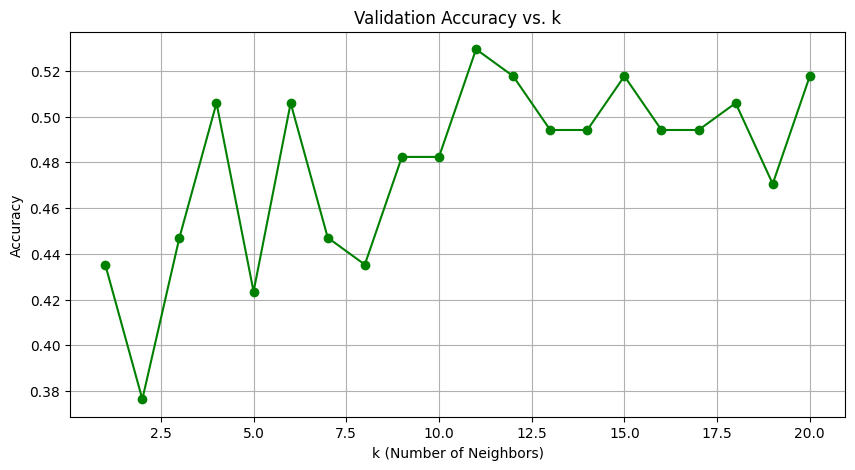

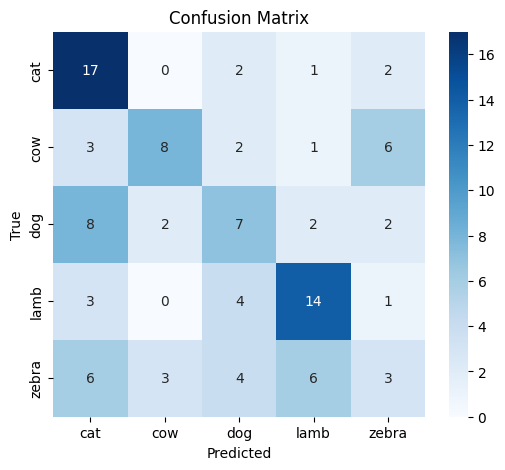

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dataset path and categories
data_dir = '/kaggle/input/animal-images/dataset'
categories = ['cat', 'cow', 'dog', 'lamb', 'zebra']

X = []
y = []

# Function to extract color histogram for RGB
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins,
                        [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Load images and extract histograms
for category in categories:
    folder_path = os.path.join(data_dir, category)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            hist = extract_color_histogram(img)
            X.append(hist)
            y.append(category)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

X = np.array(X)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train+Val and Test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Further split Train+Val into Train and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Apply PCA preserving 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Original features: {X.shape[1]}")
print(f"Reduced features after PCA: {X_train_pca.shape[1]}")

# Hyperparameter tuning on validation set
val_accuracies = []
print("\n🔧 Validation Accuracy for Different k:")
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    val_pred = knn.predict(X_val_pca)
    acc = accuracy_score(y_val, val_pred)
    val_accuracies.append(acc)
    print(f"k={k} --> Validation Accuracy: {acc:.2f}")

# Select best k and retrain on Train+Validation data
best_k = np.argmax(val_accuracies) + 1
print(f"\n✅ Best k from validation: {best_k}")

X_train_val_pca = pca.transform(X_train_val)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_val_pca, y_train_val)

# Evaluate on test set
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot validation accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), val_accuracies, marker='o', color='green')
plt.title('Validation Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
